In [1]:
import pandas as pd

df_price = pd.read_csv('data\cabbage_price.CSV')
df_amount = pd.read_csv('data\cabbage_amount.CSV')

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:4: SyntaxWarning: invalid escape sequence '\c'
C:\Users\cksdn\AppData\Local\Temp\ipykernel_3200\2292955276.py:3: SyntaxWarning: invalid escape sequence '\c'
  df_price = pd.read_csv('data\cabbage_price.CSV')
C:\Users\cksdn\AppData\Local\Temp\ipykernel_3200\2292955276.py:4: SyntaxWarning: invalid escape sequence '\c'
  df_amount = pd.read_csv('data\cabbage_amount.CSV')


In [2]:
df_price.head()

,DATE,품목명,단위(키로),등급명,평균가격,전일,전년
0,2025-03-25,배추,10,특,16866,17664,0
1,2025-03-25,배추,10,상,13020,13914,0
2,2025-03-25,배추,10,중,9132,9473,0
3,2025-03-25,배추,10,하,7686,7720,0
4,2025-03-24,배추,10,특,17664,0,13029


In [3]:
df_amount.head()

,DATE,품목명,총반입량,전일,전년
0,2025-03-24,배추,531,0,0
1,2025-03-22,배추,430,535,385
2,2025-03-21,배추,535,637,395
3,2025-03-20,배추,637,508,361
4,2025-03-19,배추,508,388,388


3월 22일 이후 데이터는 활용 할 수 없음   
DATE로 JOIN, 총반입량만 필요함    
단위 10키로망대 ->단위(kg) 10    
반입량 분배는 어캐하지  다 넣기, 1/n  반입량의 5 35 40 20 비율율
품목별 생산지는 여러 곳 날씨 고정 어캐하지? 폭염, 장마, 이상기후가 보통 영향을 줌 날씨 보류  
가락시장은 서울시 가락동 여길 기준으로?  
0은 null로 replace  
특 상 binary화 True False

In [4]:
df_amount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1590 entries, 0 to 1589
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    1590 non-null   object
 1   품목명     1590 non-null   object
 2   총반입량    1590 non-null   int64 
 3   전일      1590 non-null   int64 
 4   전년      1590 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 62.2+ KB


In [5]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7244 entries, 0 to 7243
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    7244 non-null   object
 1   품목명     7244 non-null   object
 2   단위(키로)  7244 non-null   int64 
 3   등급명     7244 non-null   object
 4   평균가격    7244 non-null   int64 
 5   전일      7244 non-null   int64 
 6   전년      7244 non-null   int64 
dtypes: int64(4), object(3)
memory usage: 396.3+ KB


어떻게 컴팩트하게 예측?

In [6]:
df_price['평균가격'] = pd.to_numeric(df_price['평균가격'])

In [7]:
import pandas as pd

# CSV 불러오기
price_df = pd.read_csv('data/cabbage_price.csv')
amount_df = pd.read_csv('data/cabbage_amount.csv')

# DATE 기준으로 merge
merged_df = pd.merge(price_df, amount_df[['DATE', '총반입량']], on='DATE', how='left')

# 등급 비율 정의
grade_ratio = {
  '특': 0.05,
  '상': 0.35,
  '보통': 0.40,
  '하': 0.20
}

# 비율 적용해서 반입량 계산
def calculate_amount(row):
  grade = row['등급명']
  total_amount = 0 if pd.isna(row['총반입량']) else row['총반입량']
  return int(total_amount * grade_ratio.get(grade, 0))


merged_df['반입량'] = merged_df.apply(calculate_amount, axis=1)

# 중, 보통, 하 제거
filtered_df = merged_df[~merged_df['등급명'].isin(['중', '보통', '하'])]

# 등급명 binary
filtered_df['등급명'] = filtered_df['등급명'].map({'특': 1, '상': 0})

# 총반입량 컬럼 제거하고 결과 확인
filtered_df = filtered_df.drop(columns=['총반입량'])

# 결과 저장 또는 출력
filtered_df.to_csv('data/filtered_cabbage_price.csv', index=False)
print(filtered_df.head())


         DATE 품목명  단위(키로)  등급명   평균가격     전일     전년  반입량
0  2025-03-25  배추      10    1  16866  17664      0    0
1  2025-03-25  배추      10    0  13020  13914      0    0
4  2025-03-24  배추      10    1  17664      0  13029   26
5  2025-03-24  배추      10    0  13914      0  10789  185
8  2025-03-23  배추      10    1      0  17128  13158    0


C:\Users\cksdn\AppData\Local\Temp\ipykernel_3200\851260510.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['등급명'] = filtered_df['등급명'].map({'특': 1, '상': 0})


In [8]:
import pandas as pd

# 파일 불러오기
df = pd.read_csv('data/filtered_cabbage_price.csv')

# 날짜 정렬 (시계열 안정성 확보)
df['DATE'] = pd.to_datetime(df['DATE'])

# 평균가격 0 제거
df = df[df['평균가격'] != 0].reset_index(drop=True)
df = df[df['반입량'] != 0].reset_index(drop=True)

df = df.sort_values('DATE').reset_index(drop=True)

# 저장 or 확인
df.to_csv('data/cleaned_cabbage_price.csv', index=False)
print(df.head())

        DATE 품목명  단위(키로)  등급명   평균가격  전일  전년  반입량
0 2020-01-03  배추      10    0   9494   0   0  247
1 2020-01-03  배추      10    1  10827   0   0   35
2 2020-01-04  배추      10    1  10121   0   0   23
3 2020-01-04  배추      10    0   8902   0   0  162
4 2020-01-06  배추      10    1  10208   0   0   22


In [9]:
df.describe()

,DATE,단위(키로),등급명,평균가격,전일,전년,반입량
count,3177,3177.0,3177.000000,3177.000000,3177.000000,3177.000000,3177.000000
mean,2022-08-10 17:43:20.566572288,10.0,0.499843,11205.646522,6478.251180,5515.267863,87.400063
min,2020-01-03 00:00:00,10.0,0.000000,2283.000000,0.000000,0.000000,1.000000
25%,2021-04-22 00:00:00,10.0,0.000000,7393.000000,0.000000,0.000000,19.000000
50%,2022-08-11 00:00:00,10.0,0.000000,9477.000000,6225.000000,4851.000000,51.000000
75%,2023-11-28 00:00:00,10.0,1.000000,12890.000000,10150.000000,9145.000000,135.000000
max,2025-03-24 00:00:00,10.0,1.000000,64195.000000,46310.000000,41793.000000,552.000000
std,NaN,0.0,0.500079,6190.042961,7157.887973,6221.602271,85.989255


In [ ]:
df = pd.read_csv('data/cleaned_cabbage_price.csv', parse_dates=["DATE"])

df["prev_price"] = df.groupby("등급명")["평균가격"].shift(1)
df["rolling_avg_3"] = df.groupby("등급명")["평균가격"].shift(1).rolling(3).mean()
df["inflow_change"] = df.groupby("등급명")["반입량"].pct_change()

# 전처리: 불필요한 컬럼 드랍
df.drop(columns=["품목명", "전일", "전년"], inplace=True)

# 날짜 관련 파생 변수 추가
df["weekday"] = df["DATE"].dt.weekday
df["month"] = df["DATE"].dt.month

# 목표값과 입력값 분리
X = df.drop(columns=["DATE", "평균가격"])
y = df["평균가격"]

In [11]:
print(df["rolling_avg_3"]) # 3일전 평균가

0                NaN
1                NaN
2                NaN
3                NaN
4       10147.333333
            ...     
3172    15591.333333
3173    13633.333333
3174    15175.333333
3175    13975.000000
3176    15583.000000
Name: rolling_avg_3, Length: 3177, dtype: float64


In [12]:
print(df["inflow_change"]) # 반입량 경향

0            NaN
1            NaN
2      -0.342857
3      -0.344130
4      -0.043478
          ...   
3172   -0.161290
3173   -0.197861
3174   -0.192308
3175    0.233333
3176    0.238095
Name: inflow_change, Length: 3177, dtype: float64


In [13]:
# 훈련/테스트 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습 (Random Forest)
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 성능 평가
from sklearn.metrics import mean_absolute_error, r2_score
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RandomForestRegressor MAE: {mae:.2f}, R2: {r2:.4f}")

RandomForestRegressor MAE: 956.41, R2: 0.9400


In [45]:
from lightgbm import LGBMRegressor

# 모델 정의 및 학습
lgb_model = LGBMRegressor(max_depth=7, n_estimators=200, learning_rate=0.05, random_state=42, verbose=0, num_leaves=2**7)
lgb_model.fit(X_train, y_train)

# 예측 및 평가
y_pred_lgb = lgb_model.predict(X_test)
mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print(f"LightGBM MAE: {mae_lgb:.2f}, R2: {r2_lgb:.4f}")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [46]:
from xgboost import XGBRegressor

# 모델 정의 및 학습
xgb_model = XGBRegressor(learning_rate = 0.05, max_depth = 5, n_estimators = 200, random_state=42)
xgb_model.fit(X_train, y_train)
# 예측 및 평가
y_pred_xgb = xgb_model.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"xgboost MAE: {mae_xgb:.2f}, R2: {r2_xgb:.4f}")

xgboost MAE: 851.83, R2: 0.9556


In [47]:
from catboost import CatBoostRegressor

# 모델 정의 및 학습
cat_model = CatBoostRegressor(depth=7,
  iterations=200,
  learning_rate=0.1,
  random_state=42,
  verbose=0)
cat_model.fit(X_train, y_train)

# 예측 및 평가
y_pred_cat = cat_model.predict(X_test)
mae_cat = mean_absolute_error(y_test, y_pred_cat)
r2_cat = r2_score(y_test, y_pred_cat)

print(f"catboost MAE: {mae_cat:.2f}, R2: {r2_cat:.4f}")

catboost MAE: 859.19, R2: 0.9546


In [48]:
from sklearn.model_selection import GridSearchCV

param_grid_lgb = {
  'n_estimators': [100, 200, 300],
  'max_depth': [3, 5, 7, 9],
  'learning_rate': [0.05, 0.1, 0.15]
}

grid_lgb = GridSearchCV(LGBMRegressor(random_state=42), param_grid_lgb,
                        scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
grid_lgb.fit(X_train, y_train)

print("Best LightGBM Params:", grid_lgb.best_params_)
print("Best MAE:", -grid_lgb.best_score_)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1041
[LightGBM] [Info] Number of data points in the train set: 2541, number of used features: 7
[LightGBM] [Info] Start training from score 11182.701299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [49]:
param_grid_xgb = {
  'n_estimators': [100, 200],
  'max_depth': [3, 5, 7],
  'learning_rate': [0.05, 0.1]
}

grid_xgb = GridSearchCV(XGBRegressor(random_state=42), param_grid_xgb,
                        scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
grid_xgb.fit(X_train, y_train)

print("Best XGBoost Params:", grid_xgb.best_params_)
print("Best MAE:", -grid_xgb.best_score_)


Best XGBoost Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200}
Best MAE: 985.1526927144827


In [50]:
param_grid_cat = {
  'iterations': [100, 200],
  'depth': [3, 5, 7],
  'learning_rate': [0.05, 0.1]
}

grid_cat = GridSearchCV(CatBoostRegressor(random_state=42, verbose=0), param_grid_cat,
                        scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)
grid_cat.fit(X_train, y_train)

print("Best CatBoost Params:", grid_cat.best_params_)
print("Best MAE:", -grid_cat.best_score_)


Best CatBoost Params: {'depth': 7, 'iterations': 200, 'learning_rate': 0.1}
Best MAE: 956.4090292636052


In [52]:
import numpy as np

# 3월 24일까지의 데이터 기반으로 3월 25일 특(1) 등급 예측
sample_input = pd.DataFrame([{
  "단위(키로)": 10,
  "등급명": 1,                  # '특' : 1 , '상 : 0
  "반입량": 24,
  "weekday": 2,                # 수요일
  "month": 3,
  "prev_price": 17664,          # 3월 24일의 평균가격
  "rolling_avg_3": 17192,     # 3월 21~24일 평균
  "inflow_change": -0.1538     # (26 - 30) / 30
}])

# 컬럼 순서 맞추기
sample_input = sample_input[X_train.columns]

for name, m in zip(["RandomForest", "LightGBM", "XGBoost", "CatBoost"],
                   [model, lgb_model, xgb_model, cat_model]):
  pred = m.predict(sample_input)[0]
  print(f"{name} 예측 평균가격: {pred:.0f} 원")


RandomForest 예측 평균가격: 18009 원
LightGBM 예측 평균가격: 16939 원
XGBoost 예측 평균가격: 17663 원
CatBoost 예측 평균가격: 17699 원


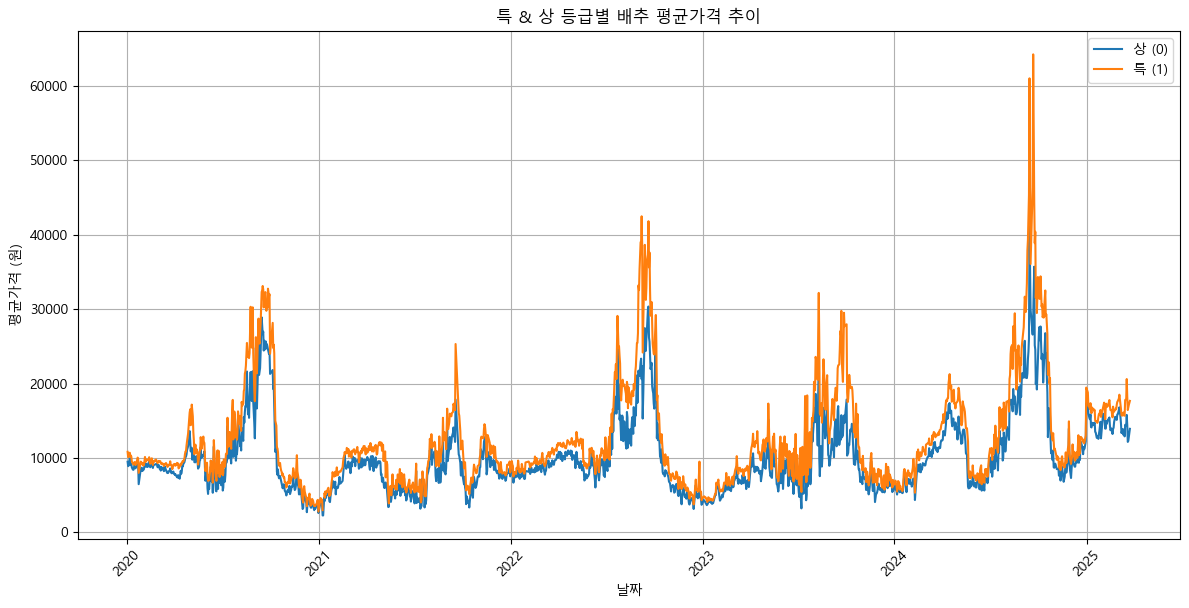

In [25]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 맑은 고딕 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 특, 상 등급만 필터링
filtered_df = df[df["등급명"].isin([0, 1])]

# 등급별 평균가격 날짜별 집계
avg_price_by_grade = filtered_df.groupby(["DATE", "등급명"])["평균가격"].mean().unstack()

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(avg_price_by_grade.index, avg_price_by_grade[0], label="상 (0)")
plt.plot(avg_price_by_grade.index, avg_price_by_grade[1], label="특 (1)")
plt.xlabel("날짜")
plt.ylabel("평균가격 (원)")
plt.title("특 & 상 등급별 배추 평균가격 추이")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


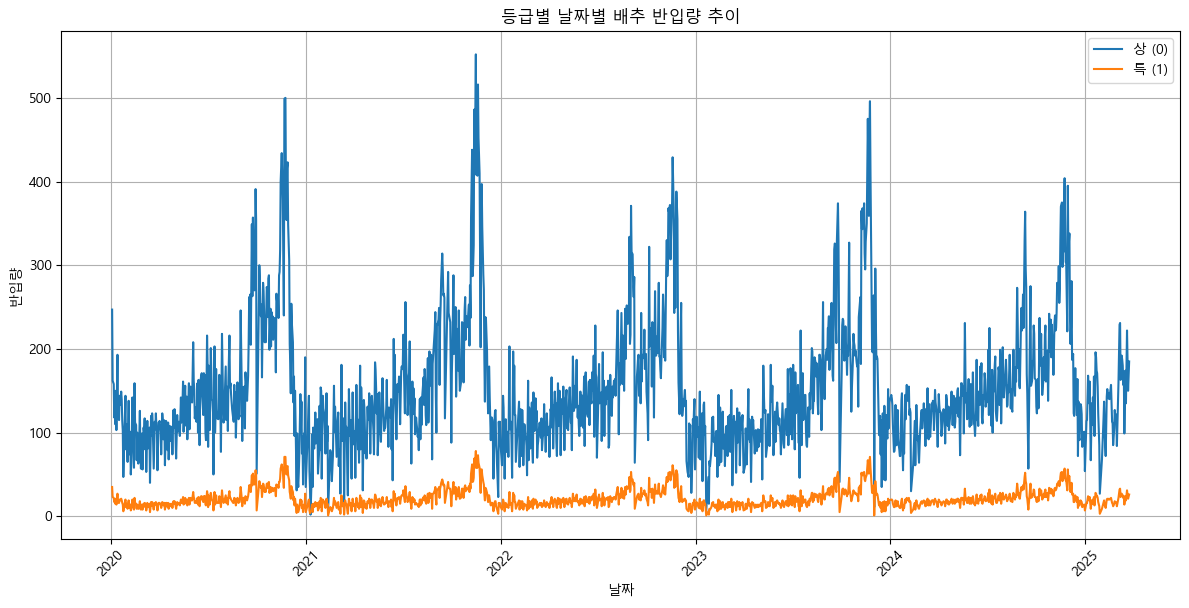

In [26]:
# 한글 폰트 설정 (맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 등급별 날짜별 반입량 집계
inflow_by_grade = df[df["등급명"].isin([0, 1])].groupby(["DATE", "등급명"])["반입량"].sum().unstack()

# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(inflow_by_grade.index, inflow_by_grade[0], label="상 (0)")
plt.plot(inflow_by_grade.index, inflow_by_grade[1], label="특 (1)")
plt.xlabel("날짜")
plt.ylabel("반입량")
plt.title("등급별 날짜별 배추 반입량 추이")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


backend:  
년 월 일 나눠서 보내기  
소매 가격 만들기  
  
data:  
피쳐 영어로 변경  
반입량이 있지만 평균 가격 없는 거 전날 가격 넣기  
평균 넣기  
최근 날짜 평균 넣기  
예측 일주일 제주도 데이콘 대회 참고  
전일 -> prev_price  
최근 경향성 -> inflow  
